# fake2vec

_You shall know a word by the company it keeps_

~John Firth


We do some exploratory analysis of the fake news articles provided by kaggle.

We then transform words to vectors using Gensims word2vec to understand the semmantics of the words used in the articles. We use the semmantic relationships to conclude the new articles are in fact very biased.

**I do not endorse and am not expressing any political affiliation or intent expressed in the articles in this dataset.**

We start by tokenizing the articles into sentences and then words; so the final result is each article is a list of lists, the inner list is a list of tokens with no punctuation.

We find the most frequent words used, and plot a histogram of document lengths.

An overview of the word2vec algorithm is given and we use the gensim package to implement word2vec. We explore what the model has discovered to be semmantically similar words visually through the TSNE algorithm.

In [51]:
# import dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import multiprocessing
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
from collections import Counter
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.models.word2vec as w2v
import sklearn.manifold
import time
sns.set_style("darkgrid")

Read in data; only keep essential columns and English language articles

In [52]:
df = pd.read_csv('fake.csv', usecols = ['uuid','author','title','text','language','site_url','country'])
df = df[df.language == 'english']
df['title'].fillna(value="", inplace=True)
df.dropna(axis=0, inplace=True, subset=['text'])
df = df.sample(frac=1.0) # shuffle the data
df.reset_index(drop=True,inplace=True)
df.head()

,uuid,author,title,text,language,site_url,country
0,c5d6ee9489749d5a10d70c7393e01479ceb91a5f,Jameson Parker,It Took Less Than 2 Hours For The New Email In...,\nHillary supporters can stop panicking. The...,english,ifyouonlynews.com,US
1,20ce164067f13c9d777d375209eb7cccd5f2337d,Corbett,Japan and Russia Might End World War 2 Soon! –...,Podcast: Play in new window | Download | Embed...,english,corbettreport.com,NL
2,36038b8a9e589c42618633888e541bf539067b3f,Colm Williamson,Clonmel Youth Call For Apology After Cat Autop...,0 Add Comment \nTEENAGERS in the county Tipper...,english,waterfordwhispersnews.com,US
3,122c8722b5ebfdeb742f237863bad219021c7a16,NaN,VIDEO : Dinesh D’Souza Delivers Powerful #Elec...,VIDEO : Dinesh D’Souza Delivers Powerful #Elec...,english,truthfeed.com,US
4,3a5a52a4af65e75466681c67c6acf8bfeec4733c,NaN,A lost opportunity for Russian statesmanship a...,A lost opportunity for Russian statesmanship a...,english,russia-direct.org,CA


### Tokenizing

We will use the nltk sent_tokenizer to tokenize our text into by sentene; this is a trained model and can distinguihs between complex sentences that have period "." in the middle

e.g.

In [54]:
example_text = "Hi there! Good morning Mr. Smith. You should check out www.example.com, its a great website"
nltk.sent_tokenize(example_text)

['Hi there!',
 'Good morning Mr. Smith.',
 'You should check out www.example.com, its a great website']

The above was tokenized correctly into 3 sentences.

Next, we want to
- Tokenize all articles by sentence
- Transform all text to lower case so that the model doesnt distinguish between cases
- Remove all websites and non alphabetical characters (punctuation, numbers, etc.)

In [55]:
def sent_tokenizer(text):
    """
    Function to tokenize sentences
    """
    text = nltk.sent_tokenize(text)
    return text

def sentence_cleaner(text):
    """
    Function to lower case remove all websites, emails and non alphabetical characters
    """
    new_text = []
    for sentence in text:
        sentence = sentence.lower()
        sentence = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", sentence)
        sentence = re.sub("[^a-z ]", "", sentence)
        sentence = nltk.word_tokenize(sentence)
        sentence = [word for word in sentence if len(word)>1] # exclude 1 letter words
        new_text.append(sentence)
    return new_text

def apply_all(text):
    return sentence_cleaner(sent_tokenizer(text))

In [56]:
t1 = time.time()
df['sent_tokenized_text'] = df['text'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(df), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 12357 articles: 1.6233540972073872 min


In [57]:
df.head()

,uuid,author,title,text,language,site_url,country,sent_tokenized_text
0,c5d6ee9489749d5a10d70c7393e01479ceb91a5f,Jameson Parker,It Took Less Than 2 Hours For The New Email In...,\nHillary supporters can stop panicking. The...,english,ifyouonlynews.com,US,"[[hillary, supporters, can, stop, panicking], ..."
1,20ce164067f13c9d777d375209eb7cccd5f2337d,Corbett,Japan and Russia Might End World War 2 Soon! –...,Podcast: Play in new window | Download | Embed...,english,corbettreport.com,NL,"[[podcast, play, in, new, window, download, em..."
2,36038b8a9e589c42618633888e541bf539067b3f,Colm Williamson,Clonmel Youth Call For Apology After Cat Autop...,0 Add Comment \nTEENAGERS in the county Tipper...,english,waterfordwhispersnews.com,US,"[[add, comment, teenagers, in, the, county, ti..."
3,122c8722b5ebfdeb742f237863bad219021c7a16,NaN,VIDEO : Dinesh D’Souza Delivers Powerful #Elec...,VIDEO : Dinesh D’Souza Delivers Powerful #Elec...,english,truthfeed.com,US,"[[video, dinesh, dsouza, delivers, powerful, e..."
4,3a5a52a4af65e75466681c67c6acf8bfeec4733c,NaN,A lost opportunity for Russian statesmanship a...,A lost opportunity for Russian statesmanship a...,english,russia-direct.org,CA,"[[lost, opportunity, for, russian, statesmansh..."


Now we want to create a list of all words to be able to generate a word frequency count. With this we can plot the a histogram of document lengths and decide the minimum number of times for a word to appear in the corpus to contribute to our model.

In [58]:
# create a list of all words using list comprehension
all_words = [word for item in list(df['sent_tokenized_text']) for word in item]
all_words = [subitem for item in all_words for subitem in item]

In [59]:
fdist = FreqDist(all_words)
len(fdist) # number of unique words

114924

The most common words, are of course, stop words; words like "the","to","a","is" which fill sentences to make them grammatically correct, but dont describe the actual context of a sentence.

We will leave these here in our analysis, but remove them in the lda_news notebook when we apply lda to the articles.

In [60]:
# show the most common words and their counts corpus wide
fdist.most_common(20)

[('the', 474135),
 ('to', 223585),
 ('of', 223417),
 ('and', 205429),
 ('in', 149168),
 ('that', 108577),
 ('is', 101033),
 ('for', 72155),
 ('on', 59705),
 ('it', 56437),
 ('as', 53156),
 ('with', 50873),
 ('are', 48235),
 ('this', 47839),
 ('by', 44737),
 ('be', 43030),
 ('was', 41690),
 ('have', 39794),
 ('not', 38503),
 ('from', 34717)]

In [61]:
# choose k and visually inspect the bottom 10 words of the top k
k = 50000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('weinglass', 3),
 ('bioenergy', 3),
 ('loneliest', 3),
 ('rbolo', 3),
 ('wombleranger', 3),
 ('lamarche', 3),
 ('darkside', 3),
 ('korb', 3),
 ('usisrael', 3),
 ('ohia', 3)]

In [62]:
# choose k and visually inspect the bottom 10 words of the top k
k = 30000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('irresponsibility', 7),
 ('nonmainstream', 7),
 ('suitability', 7),
 ('dm', 7),
 ('bahrains', 7),
 ('castigated', 7),
 ('oncoming', 7),
 ('skit', 7),
 ('prick', 7),
 ('bounces', 7)]

k = 50,000 is too high, as the bottom words aren't even real words and are very rarely used (3 times in entire corpus)

k = 30,000 seems much more reasonable as these have been used at least 7 times in the corpus

In [63]:
# get document lengths to plot histogram
def doc_length(text):
    return len([word for sent in text for word in sent])

In [64]:
# document length
df['doc_len'] = df['sent_tokenized_text'].apply(doc_length)
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

In [65]:
print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 12357 
average document length 615.799546816 
maximum document length 22894


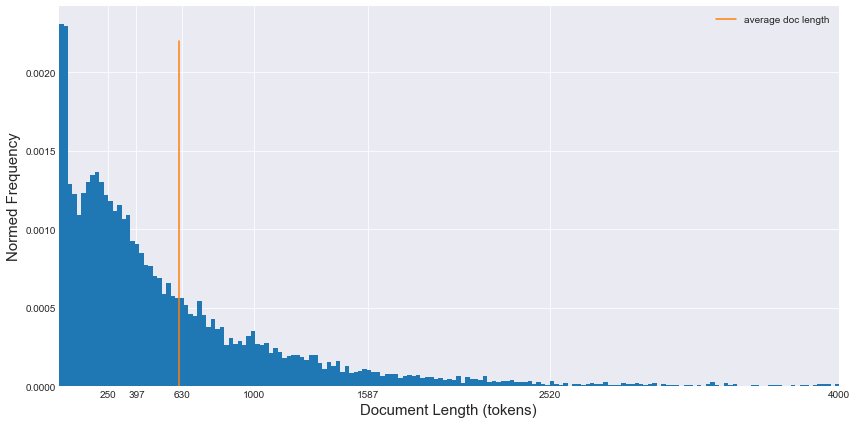

In [66]:
# plot a histogram of document length
num_bins = 1000
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins, normed=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(250),stop=np.log10(4000),num=7, base=10.0))
plt.xlim(0,4000)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0022,100)], np.linspace(0.0,0.0022,100), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

Now create a list of lists of all sentences.

The word2vec model will be trained on the all_sentences variable

In [67]:
all_sentences = list(df['sent_tokenized_text'])
all_sentences = [subitem for item in all_sentences for subitem in item]
all_sentences[:2] # print first 5 sentences

[['hillary', 'supporters', 'can', 'stop', 'panicking'],
 ['the',
  'reopening',
  'of',
  'the',
  'fbis',
  'email',
  'investigation',
  'story',
  'blasted',
  'out',
  'by',
  'every',
  'hungry',
  'reporter',
  'and',
  'desperate',
  'republican',
  'has',
  'already',
  'completely',
  'fallen',
  'apart']]

In [68]:
token_count = sum([len(sentence) for sentence in all_sentences])
print("The corpus contains {0:,} tokens".format(token_count)) # total words in corpus

The corpus contains 7,609,435 tokens


## Word2vec

At a high level, word2vec turns all words from a corpus into vectors in some medium dimensional (100-300) vector space. This vector space can be thought of as a "semmantic" or "contextual" vector space. In this vector space, words that are close to each other, in a euclidean distance sense, are semmantically simmilar. For example, the words "car" and "engine" would be semmantically close to each other, or the words "machine" and "learnig" would also be semmantically close to each other. The word2vec does this in a completely unsupervised way, simply by calculating distributions for words and a surrounding window of context words.

This representation of words, more formally known as word embeddings, is extremely useful for understanding language and sentiment in a corpus. One thing I want to stress here, is that word2vec is a completely unsupervised algorithm; this means we do not need to label or classify any data - simply feed the algorithm the raw sentence tokenized text and it will derive the word embeddings itself. Given it is unsupervised, when you see the results, you will be amazed!

Word2vec uses a 2 layer neural network to learn word embeddings. It does so in the following way

1) Weight matrices are randomly initialised

2) OHE word vectors are multiplied by the input weight matrix

3) The output of 2) is passed through a softmax function to transform the values into probabilities

4) The output of 3) is multiplied by an output weight matrix

5) An error is computed using the negative log likelihood of the softmax function

6) This error is **backpropagated** through the network to update the weight matrices

7) This process is reapeted using gradient descent until the error is minimised

As it would be very expensive to update all word vectors at every iteration, optimised methods of reducing the number of updates such as negative sampling or hierarchical softmax are used to improve efficiency.

### Hyperparameters

Some last and very quick comments on word2vec hyperparamaters:

- num_features is the number of dimensions we want to embed our words in (the length of the final word vectors)
- min_word_count, if the count of a words use is below this threshold, corpus wide, ignore the word
- context_size is the window size left and right of the target word to consider words

In [69]:
num_features = 300 # number of dimensions
# if any words appear less than min_word_count amount of times, disregard it
# recall we saw that the bottom 10 of the top 30,000 words appear only 7 times in the corpus, so lets choose 10 here
min_word_count = 10
num_workers = multiprocessing.cpu_count()
context_size = 7 # window size around target word to analyse
downsampling = 1e-3 # downsample frequent words
seed = 1 # seed for RNG

In [70]:
# setting up model with parameters above
fake2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [71]:
fake2vec.build_vocab(all_sentences)

In [72]:
print("Word2Vec vocabulary length:", len(fake2vec.wv.vocab))

Word2Vec vocabulary length: 25818


In [73]:
# number of sentences
fake2vec.corpus_count

348219

In [74]:
# train word2vec - this may take a minute...
fake2vec.train(all_sentences, total_examples=fake2vec.corpus_count, epochs=fake2vec.iter)

29279898

In [75]:
# dense 2D matrix of word vectors
all_word_vectors_matrix = fake2vec.wv.syn0

In [76]:
all_word_vectors_matrix.shape # .shape[0] are the top words we are considering in training word2vec

(25818, 300)

### TSNE

T Stochastic Neighbour Embedding is a dimensionality reduction method, specifically for manifold leanring and visualisation.

Essentially tsne computes euclidean distances between points in a high dimensional space, maps these two a lower dimensional space (usually 2 or 3) while preserving local structure. It does this by centering a gaussian on every point and scaling the euclidean distance between points by that gaussian. It then minimizes the distance difference between the high dimensional space and the low dimensional space via gradient descent on the Kullback-Leiblier divergence of probabilities between the high dimensional space and low dimensional space.

_The visual output of TSNE is a 2D map where we arbitrarily call the axes 'X' and 'Y'; these axes dont actually represent the original data in any way (unlike a linear combination from PCA), so we do not need to interpret their meaning. Each point on the map is a unique word in the corpus, and points that are close to each other, in a euclidean sense, are words that word2vec has calculated to be contextually similar._

More sophistciated and accurate explanations can be found in videos and documentation, but I thought I'd give a quick overview here before I started using the method.

In [77]:
# train tsne model for visualisation
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
t1 = time.time()
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)
t2 = time.time()
print("time to train TSNE on", all_word_vectors_matrix.shape[0], "word vectors:", (t2-t1)/60, "min")

time to train TSNE on 25818 word vectors: 18.707351998488107 min


In [78]:
# create a dataframe *points* to store the 2D embeddings of all words
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[fake2vec.wv.vocab[word].index])
            for word in fake2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [79]:
def plot_region(x_bounds, y_bounds):
    """
    This function defines regions of the tsne map
    in which to zoom in on
    """
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

In [80]:
points.head(10)

,word,x,y
0,hillary,-6.744248,26.739258
1,supporters,5.815872,-2.981937
2,can,-14.242057,-5.764681
3,stop,16.640221,-3.912024
4,panicking,-4.832084,-1.152846
5,the,-2.553517,3.669566
6,reopening,-8.730699,27.002110
7,of,-2.290215,3.553885
8,fbis,-8.909414,27.260281
9,email,-14.550614,27.500566


In [81]:
sns.set_context("poster")

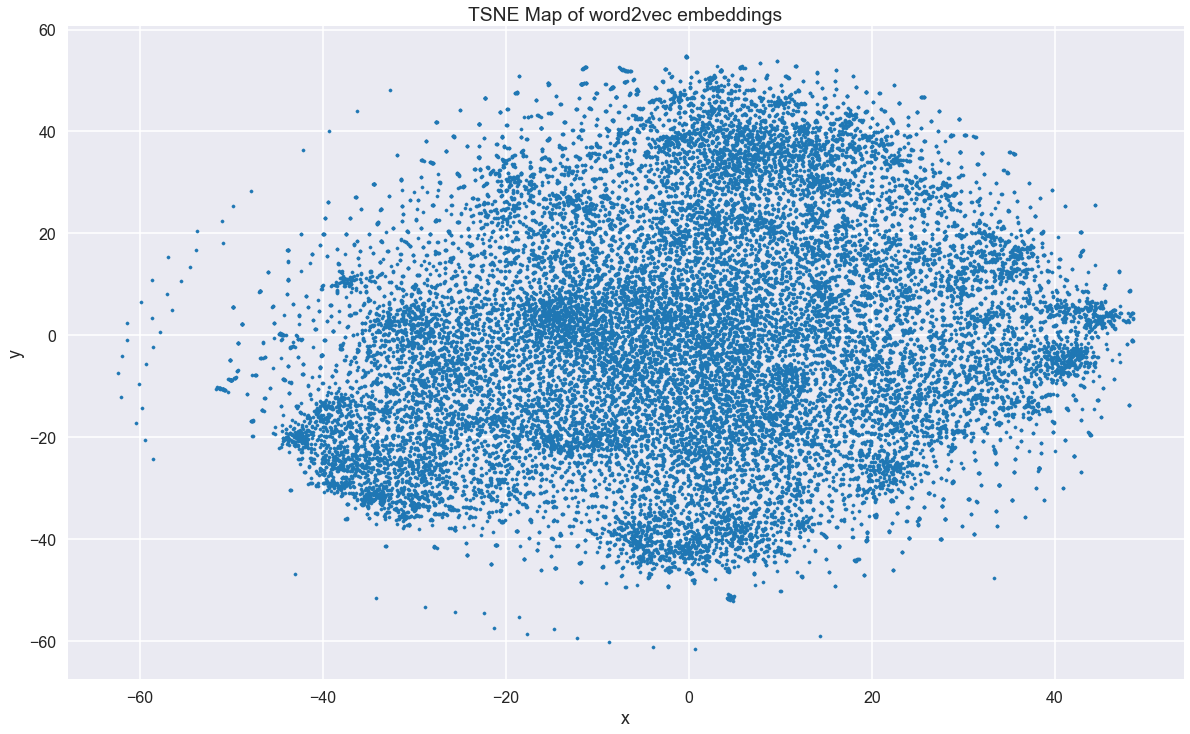

In [105]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12), title="TSNE Map of word2vec embeddings")

The points above may look like random unorganised noise, but if we zoom into any dense region we see that all words nearby are related.

#### Numbers

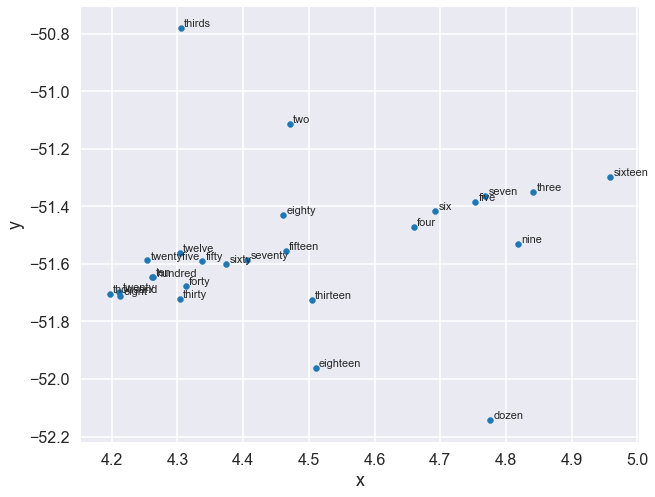

In [84]:
plot_region((3,5), (-53,-50))

#### Medical Issues / Anatomy

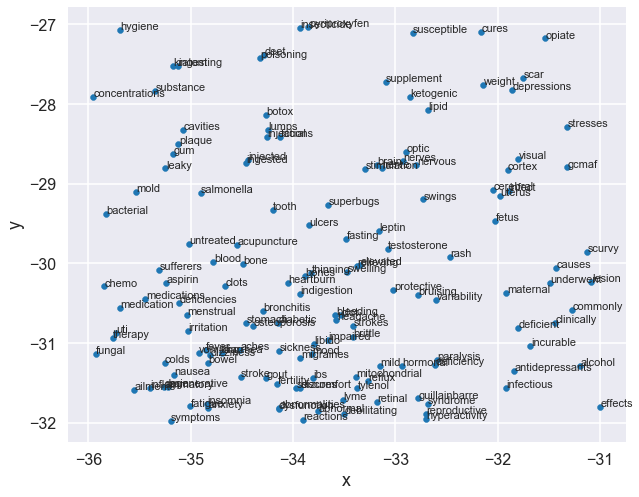

In [87]:
plot_region((-36,-31), (-32,-27))

#### Military Equipment

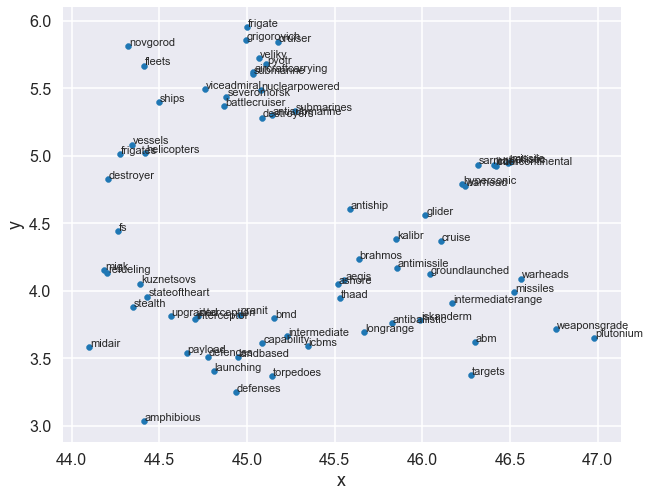

In [90]:
plot_region((44,47), (3,6))

#### Names

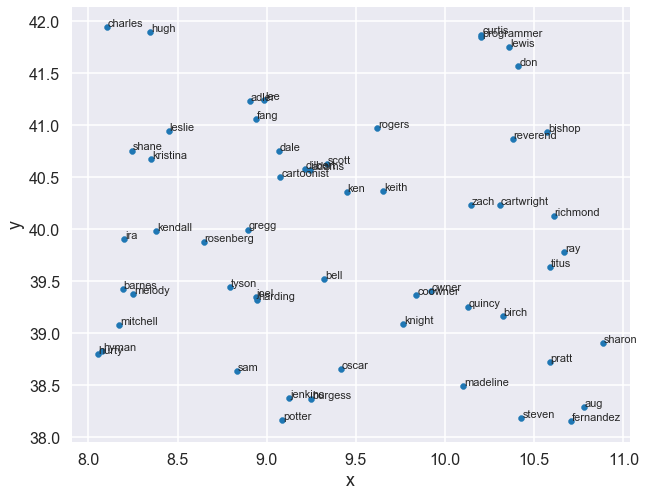

In [92]:
plot_region((8,11), (38,42))

#### CAUTION: Biases ahead

Gensim's word2vec has a method **.most_similar**, which takes the cosine similarity between the input word vector and all other word vectors and returns the most similar words i.e. words with the smallest angle between there vectors.

In [93]:
# similar word relations
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = fake2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [94]:
fake2vec.most_similar('muslim')

[('brotherhood', 0.6314252018928528),
 ('freeloaders', 0.6008124351501465),
 ('nonmuslim', 0.5597876310348511),
 ('somali', 0.5423370599746704),
 ('muslims', 0.5355566740036011),
 ('devout', 0.5311284065246582),
 ('invaders', 0.5167787075042725),
 ('holiest', 0.5147660970687866),
 ('nonmuslims', 0.5041071176528931),
 ('alsharif', 0.4877769947052002)]

In [95]:
fake2vec.most_similar('trump')

[('donald', 0.6969393491744995),
 ('trumps', 0.6097588539123535),
 ('presumptive', 0.5738163590431213),
 ('yuge', 0.5329024195671082),
 ('mustwin', 0.5295951962471008),
 ('donalds', 0.5272634029388428),
 ('temperamentally', 0.5248627662658691),
 ('cuckservatives', 0.5215535759925842),
 ('disavowed', 0.5174380540847778),
 ('demagogue', 0.5172113180160522)]

In [96]:
fake2vec.most_similar('clinton')

[('hillary', 0.6510154008865356),
 ('clintons', 0.6429455280303955),
 ('hilary', 0.5491980910301208),
 ('presumptive', 0.544337272644043),
 ('influencepeddling', 0.5297383069992065),
 ('snatch', 0.5286159515380859),
 ('cosby', 0.5181233882904053),
 ('pinchuk', 0.5153954029083252),
 ('perjured', 0.5125749111175537),
 ('crooked', 0.5123158693313599)]

In [97]:
nearest_similarity_cosmul("trump", "presidentelect", "clinton") # makes sense

trump is related to presidentelect, as hillary is related to clinton


'hillary'

In [103]:
nearest_similarity_cosmul("cancer", "body", "trump") # what?

cancer is related to body, as donald is related to trump


'donald'

## Conclusion

- The corpus of fake news was visually inspected, primarily through understanding the distribution in document length
- The corpus was tokenized by sentence so as to be used for training by word2vec
- We visually inspected the bottom words of the top 50,000 and top 30,000 words by count to get an understanding of how often these words are used. This lead us to use 10 as the minimum word count in word2vec
- The word2vec model was trained
- A TSNE model was trained on the output of word2vec to visually inspect the data
- We saw that, by zooming into the TSNE map, close clusters of words were in fact semmantically related. We gave several visual examples
- There are clearly extreme biases in the articles if the closest words to "Muslim" are "Brotherhood" and "Freeloaders"; another example of closest words are "Clinton" and "Crooked"... clearly biased. This further shows that these news articles are fake
- We now have a basis on which to build out LDA model in the next notebook, as we know the documents lengths are long enough for LDA and that the articles, albeit fake, have some structure and classification so that such a model could be trained on it